In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline

import pickle
from datetime import datetime, date
from datetime import timedelta

from sklearn.preprocessing import StandardScaler

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/result/df_subs.csv', index_col=0)
df.shape

(336576, 32)

In [4]:
df = df.loc[df['plans_0_kbk'].notna()]
df = df.loc[df['receiver_regDate_db'].notna()]
df.shape

(95649, 32)

In [5]:
df['receiver_inn'].nunique()

5771

In [6]:
df.head(5)

,info_sum,info_dateAgreem,grbs_inn,grbs_location,grbs_kbkInput,grbs_ogrn,receiver_inn,receiver_oktmo,receiver_localAddress,receiver_codeReestrGrbs,receiver_ogrn,addagreement_sumsubcur,marks_value,marks_date,marks_okei,infoind_value,infoind_okei,infosub_volretsub,infocost_volimplemcost,plans_0_purpose,plans_0_kbk,plans_0_sumTotal,plans_1_purpose,plans_1_kbk,plans_1_sumTotal,plans_2_purpose,plans_2_kbk,plans_2_sumTotal,construct,receiver_ogrn_db,receiver_regDate_db,receiver_oktmoCode_db
1,150100900.0,{'$date': '2014-01-20T01:00:00.000Z'},7.710539e+09,"73,Москва,125993,город Москва,45382000,",74,NaN,7701012399,NaN,"{'regionCode': '73', 'regionName': 'г.Москва',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ИНЫЕ ЦЕЛИ,07407060210059612241,143050800.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ИНЫЕ ЦЕЛИ,07407060213893612241,200000.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ИНЫЕ ЦЕЛИ,07407060213894612241,6261400.0,NaN,1027700350699,1992-09-04T00:00:00,45375000.0
2,387835900.0,{'$date': '2016-01-11T00:00:00.000Z'},7.710539e+09,"73,Москва,125993,город Москва,45382000,",74,NaN,7701012399,NaN,"{'regionCode': '73', 'regionName': 'г.Москва',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07401100210190059611,4075300.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407060210190059611,372510600.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407080210190059611,11250000.0,NaN,1027700350699,1992-09-04T00:00:00,45375000.0
3,410989800.0,{'$date': '2014-01-09T01:00:00.000Z'},7.710539e+09,"73,Москва,125993,город Москва,45382000,",74,NaN,7701012399,NaN,"{'regionCode': '73', 'regionName': 'г. Москва'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07401100210059611241,10762900.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407060210059611241,352901000.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407080210059611241,47325900.0,NaN,1027700350699,1992-09-04T00:00:00,45375000.0
5,448939100.0,{'$date': '2014-12-25T00:00:00.000Z'},7.710539e+09,"73,Москва,125993,город Москва,45382000,",74,NaN,7701012399,NaN,"{'regionCode': '73', 'regionName': 'г. Москва'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07401100210059611241,4982300.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407060210059611241,351547000.0,СУБСИДИИ ИЗ ФЕДЕРАЛЬНОГО БЮДЖЕТА НА ФИНАНСОВОЕ...,07407080210059611241,92409800.0,NaN,1027700350699,1992-09-04T00:00:00,45375000.0
12,620097.0,{'$date': '2014-02-03T01:00:00.000Z'},7.710539e+09,"73,Москва,125993,город Москва,45382000,",74,NaN,7701012399,NaN,"{'regionCode': '73', 'regionName': 'г. Москва'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Предоставление Организации субсидии из федерал...,07401101466162612241,220097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1027700350699,1992-09-04T00:00:00,45375000.0


In [261]:
# save for front test
cols = [
    'receiver_inn',
    'plans_0_purpose',
    'plans_0_kbk',
    'receiver_oktmo'
]
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95649 entries, 1 to 336541
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   receiver_inn     95649 non-null  int64  
 1   plans_0_purpose  95649 non-null  object 
 2   plans_0_kbk      95649 non-null  object 
 3   receiver_oktmo   20061 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.6+ MB


In [266]:
df[cols].loc[df['receiver_oktmo'].notna()].head(3000).to_csv('data/result/sample_inn_kbk.csv', index=False)

### Формируем список основных характеристик организации, используемых для модели:
1. Дней с регистрации receiver_regDate_db
2. Сумма субсидии info_sum
3. Дней с предыдущей субсидии days_between_info_dateAgreem_date
4. Брал ли до этого субсидии get_subs_before
5. регион receiver_oktmoCode_db
6. Общая сумма субсидии 0 plans_0_sumTotal
7. Общая сумма субсидии 1 plans_1_sumTotal
8. Общая сумма субсидии 2 plans_2_sumTotal

In [8]:
df['receiver_regDate_db'] = pd.to_datetime(df['receiver_regDate_db'])
df['receiver_days_from_reg'] = (pd.to_datetime(date.today()) - df['receiver_regDate_db']).dt.days

df['info_dateAgreem_date'] = pd.to_datetime(df['info_dateAgreem'].str.split(": '").str[1].str.split("T").str[0])
df = df.sort_values(by='info_dateAgreem_date')
df['prev_info_dateAgreem_date'] = df.groupby('receiver_inn')['info_dateAgreem_date'].shift()
df['days_between_info_dateAgreem_date'] = (df['info_dateAgreem_date'] - df['prev_info_dateAgreem_date']).dt.days
df['get_subs_before'] = 0
df.loc[df['days_between_info_dateAgreem_date']>0, 'get_subs_before'] = 1

In [9]:
final_cols = [
    'info_dateAgreem_date',
    'receiver_inn',
    'plans_0_kbk',
    'info_sum',
    'receiver_days_from_reg',
    'receiver_oktmoCode_db',
    'days_between_info_dateAgreem_date',
    'get_subs_before',
    'plans_0_sumTotal',
    'plans_1_sumTotal',
    'plans_2_sumTotal'
]
df_final = df[final_cols].fillna(0)
df_final.to_csv('data/result/df_subs_final_for_model.csv')

In [10]:
# Проверяем, что сумма в plans_0_sumTotal не всегда совпадает с суммой субсидий info_sum
df['sum_check'] = df['info_sum'] - df['plans_0_sumTotal']
df.loc[df['sum_check']!=0].shape

(30047, 38)

In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95649 entries, 257955 to 185906
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   info_dateAgreem_date               95649 non-null  datetime64[ns]
 1   receiver_inn                       95649 non-null  int64         
 2   plans_0_kbk                        95649 non-null  object        
 3   info_sum                           95649 non-null  float64       
 4   receiver_days_from_reg             95649 non-null  int64         
 5   receiver_oktmoCode_db              95649 non-null  float64       
 6   days_between_info_dateAgreem_date  95649 non-null  float64       
 7   get_subs_before                    95649 non-null  int64         
 8   plans_0_sumTotal                   95649 non-null  float64       
 9   plans_1_sumTotal                   95649 non-null  float64       
 10  plans_2_sumTotal            

### Создаем гибридную модель для рекомендаций с учетом характеристик пользователя:

In [12]:
df_final['info_dateAgreem_date'].min(), df_final['info_dateAgreem_date'].max()

(Timestamp('1991-04-19 00:00:00'), Timestamp('2018-01-24 00:00:00'))

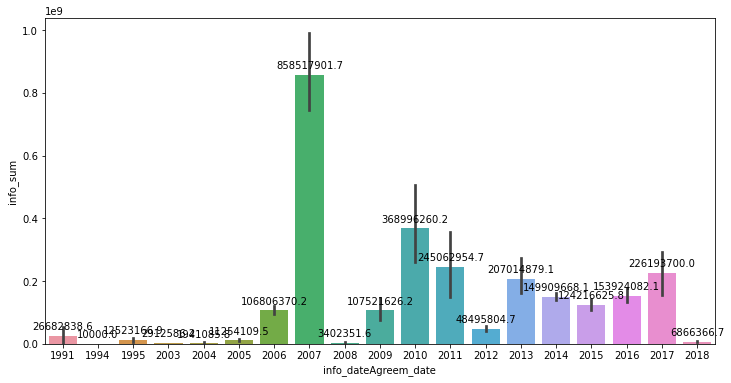

In [18]:
rcParams['figure.figsize'] = 12, 6
g = sns.barplot(x=df_final['info_dateAgreem_date'].dt.year, y='info_sum', data=df_final)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

In [52]:
# Делим данные на трейн/тест примерно 80/20 по дате:
sep_date = '2016-01-25'
df_final.rename(columns={'receiver_inn': 'user_id', 'plans_0_kbk': 'item_id'}, inplace=True)
df_final.columns = [col.lower() for col in df_final.columns]

data_train = df_final.loc[df_final['info_dateagreem_date']<=sep_date][['user_id', 'item_id', 'info_sum']]
data_test = df_final.loc[df_final['info_dateagreem_date']>sep_date][['user_id', 'item_id', 'info_sum']]
data_train.shape[0], data_test.shape[0]

(76317, 19332)

In [48]:
df_final.head(2)

,info_dateAgreem_date,user_id,item_id,info_sum,receiver_days_from_reg,receiver_oktmoCode_db,days_between_info_dateAgreem_date,get_subs_before,plans_0_sumTotal,plans_1_sumTotal,plans_2_sumTotal
257955,1991-04-19,7901529924,15010030710552900530,53360500.0,5247,9.970100e+10,0.0,0,53360500.0,0.0,0.0
257956,1991-04-19,7901529924,15010030710552900530,53360500.0,5247,9.970100e+10,0.0,0,53360500.0,0.0,0.0


In [54]:
user_features1 = df_final.groupby('user_id').agg({
    'item_id': 'count', 
    'info_sum': 'sum',
    'receiver_days_from_reg': 'max',
    'days_between_info_dateagreem_date': 'mean',
    'plans_0_sumtotal': 'sum',
    'plans_1_sumtotal': 'sum',
    'plans_2_sumtotal': 'sum'
}).reset_index()
user_features1.rename(columns={
    'item_id': 'item_id_count', 
    'info_sum': 'info_sum_sum',
    'receiver_days_from_reg': 'max_receiver_days_from_reg',
    'days_between_info_dateagreem_date': 'mean_days_between_info_dateagreem_date',
    'plans_0_sumtotal': 'sum_plans_0_sumtotal',
    'plans_1_sumtotal': 'sum_plans_1_sumtotal',
    'plans_2_sumtotal': 'sum_plans_2_sumtotal'
}, inplace=True)
user_features1.head(2)

,user_id,item_id_count,info_sum_sum,max_receiver_days_from_reg,mean_days_between_info_dateagreem_date,sum_plans_0_sumtotal,sum_plans_1_sumtotal,sum_plans_2_sumtotal
0,105000819,6,9.138303e+06,10404,31.000000,9138303.0,0.0,0.0
1,105004620,14,1.665990e+08,10006,53.857143,122365836.0,44233134.0,0.0


In [55]:
user_features2 = df_final.groupby('user_id').agg({
    'item_id': 'nunique', 
    'info_sum': 'mean',
    'days_between_info_dateagreem_date': 'max',
    'plans_0_sumtotal': 'mean',
    'plans_1_sumtotal': 'mean',
    'plans_2_sumtotal': 'mean'
}).reset_index()
user_features2.rename(columns={
    'item_id': 'item_id_nunique', 
    'info_sum': 'info_sum_mean',
    'days_between_info_dateagreem_date': 'max_days_between_info_dateagreem_date',
    'plans_0_sumtotal': 'mean_plans_0_sumtotal',
    'plans_1_sumtotal': 'mean_plans_1_sumtotal',
    'plans_2_sumtotal': 'mean_plans_2_sumtotal'
}, inplace=True)
user_features2.head(2)

,user_id,item_id_nunique,info_sum_mean,max_days_between_info_dateagreem_date,mean_plans_0_sumtotal,mean_plans_1_sumtotal,mean_plans_2_sumtotal
0,105000819,1,1.523050e+06,186.0,1.523050e+06,0.000000e+00,0.0
1,105004620,3,1.189993e+07,365.0,8.740417e+06,3.159510e+06,0.0


In [56]:
user_features = pd.merge(user_features1, user_features2, how="left", on='user_id')
user_features.head(2)

,user_id,item_id_count,info_sum_sum,max_receiver_days_from_reg,mean_days_between_info_dateagreem_date,sum_plans_0_sumtotal,sum_plans_1_sumtotal,sum_plans_2_sumtotal,item_id_nunique,info_sum_mean,max_days_between_info_dateagreem_date,mean_plans_0_sumtotal,mean_plans_1_sumtotal,mean_plans_2_sumtotal
0,105000819,6,9.138303e+06,10404,31.000000,9138303.0,0.0,0.0,1,1.523050e+06,186.0,1.523050e+06,0.000000e+00,0.0
1,105004620,14,1.665990e+08,10006,53.857143,122365836.0,44233134.0,0.0,3,1.189993e+07,365.0,8.740417e+06,3.159510e+06,0.0


In [57]:
user_features['user_id'].nunique(), user_features.shape

(5771, (5771, 14))

In [58]:
data_train['item_id'].nunique(), data_train['user_id'].nunique()

(1580, 5328)

In [59]:
data_test['item_id'].nunique(), data_test['user_id'].nunique()

(888, 3628)

In [60]:
%%time
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='info_sum',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float)
uic = user_item_matrix.columns.tolist()

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

Wall time: 882 ms


item_id,00701100130059611241,00701100130059612241,00701100130290059611,00701100133987612241,00701100213893612241,00701101410059611241,00701101410059612241,00701101410190059611,00701101410190059621,00701101410290059611,00701101413987612241,00701101436146612241,00701101466162612241,00704112510059612241,00704121479999612241,00707010220059611241,00707010220059612241,00707010220190059611,00707040210059611241,00707040210059612241,00707060210059611241,00707060213893612241,00707061410890059611,00707061410890059612,00707061489999612241,00708011140059611241,00708011140059612241,00708011140290059611,00708011143987612241,00709010120059611241,00709010120059612241,00709010121054010611,00709010122009612241,00709010122010612241,00709010123999612241,00709010125401611241,00709010126087612241,00709020110059611241,00709020120059611241,00709020120059612241,00709050120059611241,00709050120059612241,00709050150190059611,00709080130296055611,00709080136055611241,00709090134009464530,02001132736006821242,02002091656421810241,02002091656422810241,02002091656854451530,020020916Ш6266451530,020020916Ш6272451530,020020916Ш6274451530,020020916Ш6278451530,020020916Ш6279451530,020020916Ш6280451530,020020916Ш6309451530,020020916Ш6335451530,020020916Ш6369451530,020020916Ш6523451530,020020916Ш6526451530,020020916Ш6544451530,020020916Ш6545451530,020020916Ш6546451530,020020916Ш6555451530,020020916Ш6561451530,020020916Ш6654451530,020020916Ш6669451530,020020916Ш6685451530,020020916Э6391451530,020020916Э6438451530,020020916Э6662451530,02002094410264210810,020041116Ц0059611241,020041116Ц0059612241,02004121615173521251,02004121616470810242,02004121616478810242,02004121616713810242,02004121620168480810,02004121640468430810,02004121646462810241,02004121646462810242,02004121646464810242,02004121646465810242,02004121646867810242,02004121650168680810,02004121656056810242,02004121656467810242,02004121656483810242,02004121656689821242,02004121656762821242,02004121660168460810,02004121696678821242,020041216Л6843810241,020041216Л6843810242,020041216Т6411810242,020041216Ц0059611241,020041216Ц0059612241,020041216Ц5480521251,020041216Ц6238630242,020041216Ц6476810242,020041216Ц6511821242,020041216Ц6846810242,020041216Ц6868810242,020041216Ш6645452530,020041216Ш6646452530,020041216Ш6648452530,020041216Ш6649452530,020041216Ш6650452530,020041216Ш6651452530,020041216Ш6668821242,020041216Ш6847452530,02004121736760821242,02004121780264750810,02004121786474810242,02004121786475810242,020041217Б6329451530,020041217Б6330451530,02004121876279451530,02004121876281451530,02004121879999466530,02004121926268451530,02004121926271451530,02004121926273451530,02004121926278451530,02004121926279451530,02004121926281451530,02004121926288451530,02004121926290451530,02004121926296451530,02004121926302451530,02004121926306451530,02004121926307451530,02004121926311451530,02004121926312451530,02004121926313451530,02004121926314451530,02004121926316451530,02004121926319451530,02004121926332451530,02004121926335451530,02004121926337451530,02004121926341451530,02004121926420451530,02004121926438451530,02004121926633451530,02004122146438451530,02004122266369451530,020041235Д0050190522,020041235Д5019522251,02004129996094810242,02008011110059611241,02008011110059612241,02009020110059612241,02204023026794451530,02204023050059611241,02204023070059611241,022040235Ж5101522251,02204029976761821242,02204029995218521251,02204029996819810242,02204113010059611241,02204113010059612241,02204113070059611241,02204113070059612241,02209010120059611241,02209010122009612241,02209010125401611241,02214033025388521251,02214033050751560540,02214033055156540251,04806031210059611241,04806031210059612241,04806031210390059611,04806051210354860530,04904042810059611241,04904042810059612241,04904042810490059611,04904042810953950530,04904042811653950530,04904042845395530251,05104011250059611241,05104011250059612241,05104042816365452530,05104062869999810241,05104062869999810242,05104091224009464530,05104121250059611241,05104121250059612241,05

In [87]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='info_sum',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
tuic = test_user_item_matrix.columns.tolist()
for col in uic:
    if col not in tuic:
        test_user_item_matrix[col] = 0

# переведем в формат saprse matrix
test_sparse_user_item = csr_matrix(test_user_item_matrix).tocsr()

test_user_item_matrix.head(2)

item_id,00701100130290059611,00701101410190059611,00701101410290059611,00707010220190059611,00707061410890059611,00707061410890059612,00708011140290059611,00709010121054010611,00709050150190059611,00709080130296055611,02002094410264210810,02004121660168460810,04806031210390059611,04904042810490059611,05204062820451280530,05204062860050160521,05204062860050160522,05407060210190059612,05408011110390059611,05408011120160160630,05408011120451480540,05408031140290059612,056041210Б0099998612,05607060210190059611,05607060210190059612,05607060210538930612,05609010120151740540,05609010120250720540,05609010120953820521,05609010120990059612,05609010121054010611,05609010121054020521,05609010150293999612,05609019990090059612,05609020110351790540,05609020110551610540,05609020110554600530,05609050150190059611,05609060121190059612,05609080120994009464,05609080130290059611,05609080130290059612,05609090110551330540,05609090120754920540,05609090120790059612,05609090190290059611,05610030311252400530,06910030510351340530,06910030510351350530,06910030540354850530,07401100210190059611,07401100210190059621,07401101410196086612,07401101410796162613,07401101410796162622,07404111470099998611,07404111470099998613,07404111470099998621,07404111470099998623,07404111470099998810,07407020220290059611,07407020220393997612,07407020240190059611,07407020240190059612,07407040210290059611,07407040210290059612,07407040210393997612,07407040210538930540,07407060210190059611,07407060210190059612,07407060210393987612,07407060210393987622,07407060210393997612,07407060210538930612,07407060210538930622,07407060210796711622,07407080210190059611,07407080210190059621,07407080250190059611,07407080250190059621,07407081430164820811,07407090210190059611,07410040330750820521,07410040330752600530,08104052560790059611,08104052560790059612,08204052510150330521,08204052510150340521,08204052510450380521,08204052510450390521,08204052510550400521,08204052520150440521,08204052520250450521,08204052520650470521,08204052520650480521,08204052520750490521,08204052530350520521,08204052540150550521,08204052540350530521,08204052540450540521,08204052540554380521,08204052590154390521,082040525Б0150430521,082040525Б0154420521,082040525Б0254430521,082040525Г0150310521,082040525Г0250420521,082040525Г0354460521,082040525Г0450500521,082040525Д0154500521,08205022570050180522,08209022570050180522,08210032570050180521,08211012570050180522,09107070240490059611,09214031010151040540,10304092420565150823,10907060210190059611,10907060210190059612,10907060210538930612,10907060213893612241,13904121520151110522,13907051570150660521,14907070330854570540,14910010310751530540,14910040330450840521,14910060410250270521,14910060420265040810,15501131110490059611,15701131590353910530,16107051510690059621,16701133810654830530,169040824Б0699998464,16904111230490059611,16906051230390059611,16906051230390059612,16906052860099998464,17101123820290059611,17101123820290059612,17107040210290059611,17107040210290059612,17703091010390059611,17703091010390059612,17703101010390059611,17703101010390059621,17703131020290059611,17707051010390059611,17707051010390059612,17707051010390059621,17707061020490059611,18702039990062270630,31803044220290059611,38014031170250910540,38014031180052360521,38607060210538930612,388090201Б0151970540,388090901Б0190059612,43801059090051200530,59708011110390059612,72504122210165080821,77707040210290059611,77707040210290059612,77707060210190059611,77707060210190059612,77707080210190059611,77711031320190059611,77711031320190059612,00701100130059611241,00701100130059612241,00701100133987612241,00701100213893612241,00701101410059611241,00701101410059612241,00701101410190059621,00701101413987612241,00701101436146612241,00701101466162612241,00704112510059612241,00704121479999612241,00707010220059611241,00707010220059612241,00707040210059611241,00707040210059612241,00707060210059611241,00707060213893612241,00707061489999612241,00708011140059611241,00708011140059612241,00708011143987612241,00709010120059611241,00

In [63]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [64]:
id_to_userid

{0: 105000819,
 1: 105004620,
 2: 105013462,
 3: 105014177,
 4: 105017210,
 5: 105017636,
 6: 105019827,
 7: 105019880,
 8: 105020815,
 9: 105022178,
 10: 105022668,
 11: 105023407,
 12: 105023439,
 13: 105037907,
 14: 105042953,
 15: 105043072,
 16: 105043139,
 17: 105044421,
 18: 105050658,
 19: 105050802,
 20: 105051570,
 21: 202000395,
 22: 209001038,
 23: 211004251,
 24: 218000136,
 25: 218000697,
 26: 226003959,
 27: 231000576,
 28: 235001919,
 29: 255002773,
 30: 261004521,
 31: 262016287,
 32: 264005146,
 33: 266007974,
 34: 266036534,
 35: 268005588,
 36: 270995195,
 37: 272010862,
 38: 273008320,
 39: 273037056,
 40: 274011237,
 41: 274013386,
 42: 274019596,
 43: 274021161,
 44: 274022366,
 45: 274023088,
 46: 274023747,
 47: 274029019,
 48: 274033199,
 49: 274034308,
 50: 274035439,
 51: 274035573,
 52: 274038133,
 53: 274043503,
 54: 274064870,
 55: 274078489,
 56: 274108180,
 57: 274110358,
 58: 274116127,
 59: 274132270,
 60: 274151019,
 61: 274151026,
 62: 274151594,
 6

In [247]:
with open('id_to_itemid.p', 'wb') as fp:
    pickle.dump(id_to_itemid, fp)
with open('id_to_userid.p', 'wb') as fp:
    pickle.dump(id_to_userid, fp)
with open('itemid_to_id.p', 'wb') as fp:
    pickle.dump(itemid_to_id, fp)
with open('userid_to_id.p', 'wb') as fp:
    pickle.dump(userid_to_id, fp)

In [65]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

display(user_feat.shape)
user_feat.head(2)

(5328, 13)

,item_id_count,info_sum_sum,max_receiver_days_from_reg,mean_days_between_info_dateagreem_date,sum_plans_0_sumtotal,sum_plans_1_sumtotal,sum_plans_2_sumtotal,item_id_nunique,info_sum_mean,max_days_between_info_dateagreem_date,mean_plans_0_sumtotal,mean_plans_1_sumtotal,mean_plans_2_sumtotal
user_id,,,,,,,,,,,,,
105000819,6,9.138303e+06,10404,31.000000,9138303.0,0.0,0.0,1,1.523050e+06,186.0,1.523050e+06,0.000000e+00,0.0
105004620,14,1.665990e+08,10006,53.857143,122365836.0,44233134.0,0.0,3,1.189993e+07,365.0,8.740417e+06,3.159510e+06,0.0


In [66]:
scaler = StandardScaler()
user_feat_lightfm = pd.DataFrame(scaler.fit_transform(user_feat), index=user_feat.index, columns=user_feat.columns)
user_feat_lightfm.head(2)

,item_id_count,info_sum_sum,max_receiver_days_from_reg,mean_days_between_info_dateagreem_date,sum_plans_0_sumtotal,sum_plans_1_sumtotal,sum_plans_2_sumtotal,item_id_nunique,info_sum_mean,max_days_between_info_dateagreem_date,mean_plans_0_sumtotal,mean_plans_1_sumtotal,mean_plans_2_sumtotal
user_id,,,,,,,,,,,,,
105000819,-0.486372,-0.111151,1.286480,-0.420714,-0.102769,-0.058606,-0.133025,-0.645517,-0.176110,-0.459522,-0.156756,-0.128048,-0.196663
105004620,-0.154254,-0.104609,1.151058,-0.102352,-0.096498,-0.052171,-0.133025,-0.291751,-0.162833,-0.138512,-0.145746,-0.099679,-0.196663


In [248]:
user_feat_lightfm.to_csv('user_feat_lightfm.csv')

In [97]:
model = LightFM(no_components=30,  # Number of elements in embedding, K
                loss='warp', # 'bpr'  # 'logistic'
                learning_rate=0.02, 
                item_alpha=0.1,
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix), # веса
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          epochs=25
         )

In [98]:
# Значение метрики precision_at_k трейна
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.13986488

In [99]:
# Значение метрики precision_at_k теста
test_precision = precision_at_k(model, test_sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.13986488

In [249]:
userid_to_id

{105000819: 0,
 105004620: 1,
 105013462: 2,
 105014177: 3,
 105017210: 4,
 105017636: 5,
 105019827: 6,
 105019880: 7,
 105020815: 8,
 105022178: 9,
 105022668: 10,
 105023407: 11,
 105023439: 12,
 105037907: 13,
 105042953: 14,
 105043072: 15,
 105043139: 16,
 105044421: 17,
 105050658: 18,
 105050802: 19,
 105051570: 20,
 202000395: 21,
 209001038: 22,
 211004251: 23,
 218000136: 24,
 218000697: 25,
 226003959: 26,
 231000576: 27,
 235001919: 28,
 255002075: 29,
 255002773: 30,
 261004521: 31,
 262007807: 32,
 262016287: 33,
 264005146: 34,
 266007974: 35,
 266036534: 36,
 267008402: 37,
 268005588: 38,
 268017209: 39,
 270010345: 40,
 270995195: 41,
 272010862: 42,
 273008320: 43,
 273015736: 44,
 273037056: 45,
 274011237: 46,
 274013386: 47,
 274019596: 48,
 274021161: 49,
 274022366: 50,
 274023088: 51,
 274023747: 52,
 274029019: 53,
 274033199: 54,
 274033209: 55,
 274034308: 56,
 274035439: 57,
 274035573: 58,
 274038133: 59,
 274043503: 60,
 274064870: 61,
 274078489: 62,
 2

In [222]:
itemid_to_id

{'00701100130059611241': 0,
 '00701100130059612241': 1,
 '00701100130290059611': 2,
 '00701100130290059612': 3,
 '00701100130293987612': 4,
 '00701100133987612241': 5,
 '00701100210538930612': 6,
 '00701100213893612241': 7,
 '00701101410059611241': 8,
 '00701101410059612241': 9,
 '00701101410190059611': 10,
 '00701101410190059612': 11,
 '00701101410190059621': 12,
 '00701101410190059622': 13,
 '00701101410193987612': 14,
 '00701101410290059611': 15,
 '00701101413987612241': 16,
 '00701101436146612241': 17,
 '00701101466162612241': 18,
 '00704112510059612241': 19,
 '00704112550290059612': 20,
 '00704121470099998612': 21,
 '00704121479999612241': 22,
 '00707010220059611241': 23,
 '00707010220059612241': 24,
 '00707010220190059611': 25,
 '00707010220190059612': 26,
 '00707040210059611241': 27,
 '00707040210059612241': 28,
 '00707040210290059611': 29,
 '00707040210290059612': 30,
 '00707060210059611241': 31,
 '00707060210538930612': 32,
 '00707060213893612241': 33,
 '00707061410890059611':

In [226]:
test_item_ids = np.array([
    itemid_to_id['00701100130290059612'],
    itemid_to_id['00707010220059611241'],
    itemid_to_id['020041235Д5019522251'],
    itemid_to_id['02204023026794451530'],
])

predictions = model.predict(user_ids=0, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            num_threads=4)
predictions

array([11.324158, 11.619265, 10.292796, 10.246357], dtype=float32)

### Сохраняем полученную модель

In [228]:
with open('model1.pickle', 'wb') as fle:
    pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

In [235]:
filename = 'model1.pickle'

In [236]:
pickle.dump(model, open(filename, 'wb'))

In [237]:
loaded_model = pickle.load(open(filename, 'rb'))

In [238]:
test_item_ids = np.array([
    itemid_to_id['00701100130290059612'],
    itemid_to_id['00707010220059611241'],
    itemid_to_id['020041235Д5019522251'],
    itemid_to_id['02204023026794451530'],
])

predictions = loaded_model.predict(user_ids=0, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            num_threads=4)
predictions

array([11.324158, 11.619265, 10.292796, 10.246357], dtype=float32)